In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px





# Lade das Datenset
charging_set = pd.read_csv("data/cleaned_charging_set.csv")
charging_set.head(3)



,id,kWhDelivered,siteID,spaceID,stationID,timezone,userID,connectionTime_date,connectionTime_time,disconnectTime_date,...,paymentRequired,requestedDeparture,UserID,WhPerMile_present,kWhRequested_present,milesRequested_present,minutesAvailable_present,modifiedAt_present,paymentRequired_present,requestedDeparture_present
0,5e23b149f9af8b5fe4b973cf,25.016,1,AG-3F30,1-1-179-810,America/Los_Angeles,194.0,2020-01-02,13:08:54,2020-01-02,...,True,"Thu, 02 Jan 2020 20:51:54 GMT",1,1,1,1,1,1,1,1
1,5e23b149f9af8b5fe4b973d0,33.097,1,AG-1F01,1-1-193-825,America/Los_Angeles,4275.0,2020-01-02,13:36:50,2020-01-02,...,True,"Thu, 02 Jan 2020 23:31:50 GMT",1,1,1,1,1,1,1,1
2,5e23b149f9af8b5fe4b973d1,6.521,1,AG-1F03,1-1-193-829,America/Los_Angeles,344.0,2020-01-02,13:56:35,2020-01-03,...,True,"Thu, 02 Jan 2020 14:56:35 GMT",1,1,1,1,1,1,1,1


Index(['id', 'kWhDelivered', 'siteID', 'spaceID', 'stationID', 'timezone',
       'userID', 'connectionTime_date', 'connectionTime_time',
       'disconnectTime_date', 'disconnectTime_time', 'doneChargingTime_date',
       'doneChargingTime_time', 'connectionTime_year', 'connectionTime_month',
       'connectionTime_day', 'disconnectTime_year', 'disconnectTime_month',
       'disconnectTime_day', 'doneChargingTime_year', 'doneChargingTime_month',
       'doneChargingTime_day', 'chargingDuration', 'WhPerMile', 'kWhRequested',
       'milesRequested', 'minutesAvailable', 'modifiedAt', 'paymentRequired',
       'requestedDeparture', 'UserID', 'WhPerMile_present',
       'kWhRequested_present', 'milesRequested_present',
       'minutesAvailable_present', 'modifiedAt_present',
       'paymentRequired_present', 'requestedDeparture_present'],
      dtype='object')


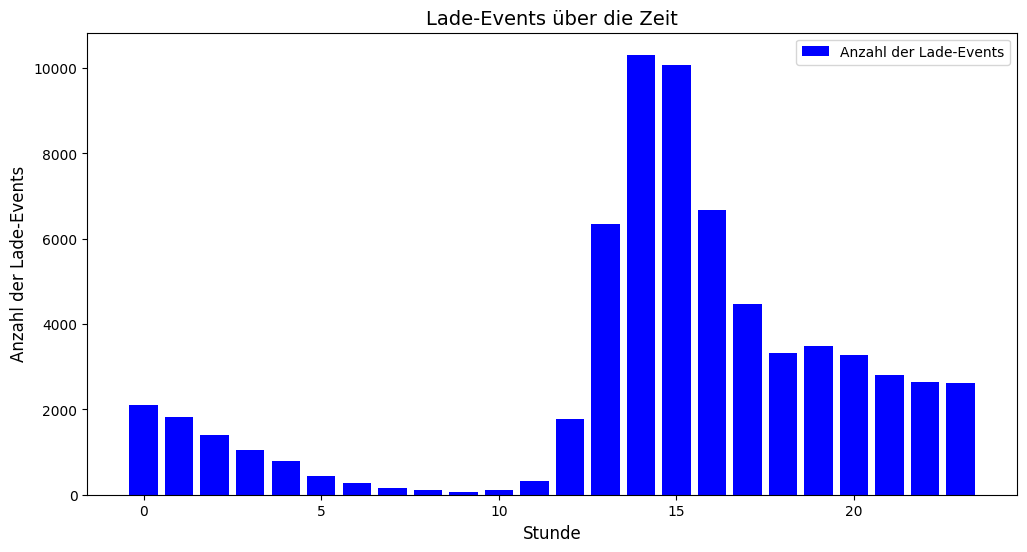

In [2]:
# Entferne NaN-Werte für die ausgewählten Features
#charging_set_cleaned = charging_set[ausgewählte_features].dropna()
print(charging_set.columns)
# Anzahl der Lade-Events pro Tag berechnen
charging_set['connectionTime_time'] = pd.to_datetime(charging_set['connectionTime_time'])
charging_set['hour'] = charging_set['connectionTime_time'].dt.hour


events_at_day = charging_set.groupby('hour').size().reset_index(name='count')


# Visualisierung der Lade-Events über die Zeit
plt.figure(figsize=(12, 6))
plt.bar(events_at_day['hour'], events_at_day['count'], color='blue', label='Anzahl der Lade-Events')
plt.title('Lade-Events über die Zeit', fontsize=14)
plt.xlabel('Stunde', fontsize=12)
plt.ylabel('Anzahl der Lade-Events', fontsize=12)
plt.grid(True, linestyle=' ', alpha=0.7)
plt.legend()
plt.show()




for site_id in [1, 2]:
    site_data = charging_set[charging_set['siteID'] == site_id]
    site_events_at_day = site_data.groupby('hour').size().reset_index(name='count')

    # Interaktive Visualisierung
    fig = px.bar(
        site_events_at_day,
        x='hour',
        y='count',
        title=f'Lade-Events über die Zeit (siteID = {site_id})',
        labels={'hour': 'Stunde', 'count': 'Anzahl der Lade-Events'},
    )

    fig.update_traces(marker_color='#1f77b4')

# Hinzufügen von Layout-Anpassungen für eine bessere Darstellung
    fig.update_layout(
        xaxis_title="Stunde",
        yaxis_title="Anzahl der Lade-Events",
        title_font_size=18,
        legend_title_text="Legende",
        template="plotly_white"
    )

    # Grafik anzeigen
    fig.show()

    # plt.figure(figsize=(12, 6))
    # plt.bar(site_events_at_day['hour'], site_events_at_day['count'], label=f'Anzahl der Lade-Events (siteID = {site_id})')
    

    
    # plt.title(f'Lade-Events pro Stunde für siteID = {site_id}', fontsize=14)
    # plt.xlabel('Stunde', fontsize=12)
    # plt.ylabel('Anzahl der Lade-Events', fontsize=12)
    # plt.grid(True, linestyle='--', alpha=0.7)
    # plt.legend()
    # plt.show()






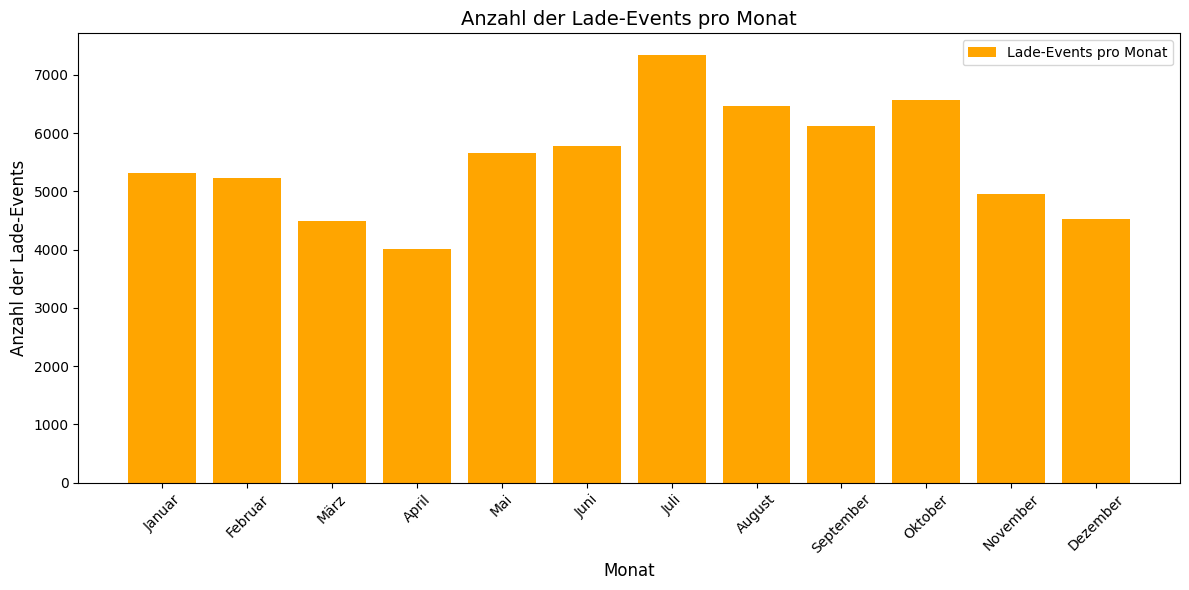

In [3]:
# Aggregation auf Monatsbasis
#events_per_month['connectionTime_date'] = events_per_month['connectionTime_date'].dt.to_timestamp()

month_names = {
    1: "Januar", 2: "Februar", 3: "März", 4: "April", 
    5: "Mai", 6: "Juni", 7: "Juli", 8: "August",
    9: "September", 10: "Oktober", 11: "November", 12: "Dezember"
}

events_per_month = charging_set.groupby('connectionTime_month').size().reset_index(name='count')

# Monatsnamen hinzufügen
events_per_month['month_name'] = events_per_month['connectionTime_month'].map(month_names)


# Visualisierung als Balkendiagramm
plt.figure(figsize=(12, 6))
plt.bar(events_per_month['month_name'], events_per_month['count'], color='orange', label='Lade-Events pro Monat')
plt.title('Anzahl der Lade-Events pro Monat', fontsize=14)
plt.xlabel('Monat', fontsize=12)
plt.ylabel('Anzahl der Lade-Events', fontsize=12)
plt.grid(axis='y', linestyle='', alpha=0.7)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
# Entferne NaN-Werte für die ausgewählten Features
#charging_set_cleaned = charging_set[ausgewählte_features].dropna()

# Anzahl der Lade-Events pro Tag berechnen
events_per_day = charging_set.groupby('connectionTime_date').size().reset_index(name='count')

# # Sicherstellen, dass connectionTime_date ein Datumstyp ist
# events_per_day['connectionTime_date'] = pd.to_datetime(events_per_day['connectionTime_date'])

# # Kontinuierliche Datumsreihe erstellen (inklusive fehlender Tage)
# full_date_range = pd.date_range(
#     start=events_per_day['connectionTime_date'].min(),
#     end=events_per_day['connectionTime_date'].max()
# )

# # Fehlende Daten mit Nullwerten auffüllen
# events_per_day = events_per_day.set_index('connectionTime_date').reindex(full_date_range, fill_value=0).reset_index()
# events_per_day.columns = ['connectionTime_date', 'count']


# # Visualisierung der Lade-Events über die Zeit
# plt.figure(figsize=(12, 6))
# plt.bar(events_per_day['connectionTime_date'], events_per_day['count'], color='blue', label='Anzahl der Lade-Events')
# plt.title('Lade-Events über die Zeit', fontsize=14)
# plt.xlabel('Datum', fontsize=12)
# plt.ylabel('Anzahl der Lade-Events', fontsize=12)
# plt.grid(True, linestyle=' ', alpha=0.7)
# plt.legend()
# plt.show()

 # Interaktive Visualisierung
fig = px.bar(
    events_per_day,
    x='connectionTime_date',
    y='count',
    title='Lade-Events über die Zeit',
    labels={'connectionTime_date': 'Datum', 'count': 'Anzahl der Lade-Events'}
)

# Einheitliche Farbe für die Balken
fig.update_traces(marker_color='#00008B')  # Blau als einheitliche Farbe

# Layout-Anpassungen für bessere Darstellung
fig.update_layout(
    xaxis_title="Datum",
    yaxis_title="Anzahl der Lade-Events",
    title_font_size=18,
    legend_title_text=None,  # Keine Legende nötig
    template="plotly_white"
)

# Grafik anzeigen
fig.show()



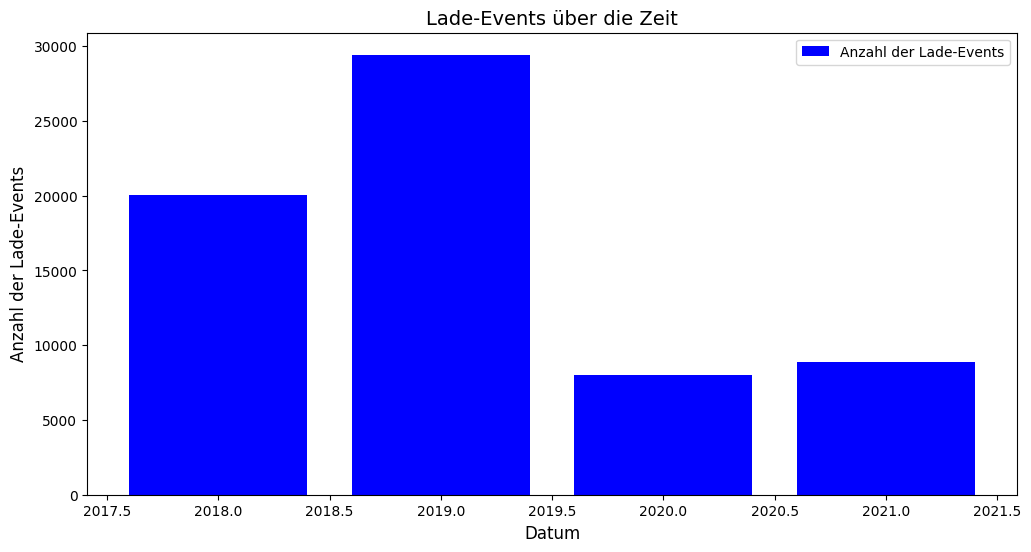

In [5]:
events_per_year = charging_set.groupby('connectionTime_year').size().reset_index(name='count')

# Visualisierung der Lade-Events über die Zeit
plt.figure(figsize=(12, 6))
plt.bar(events_per_year['connectionTime_year'], events_per_year['count'], color='blue', label='Anzahl der Lade-Events')
plt.title('Lade-Events über die Zeit', fontsize=14)
plt.xlabel('Datum', fontsize=12)
plt.ylabel('Anzahl der Lade-Events', fontsize=12)
plt.grid(True, linestyle=' ', alpha=0.7)
plt.legend()
plt.show()

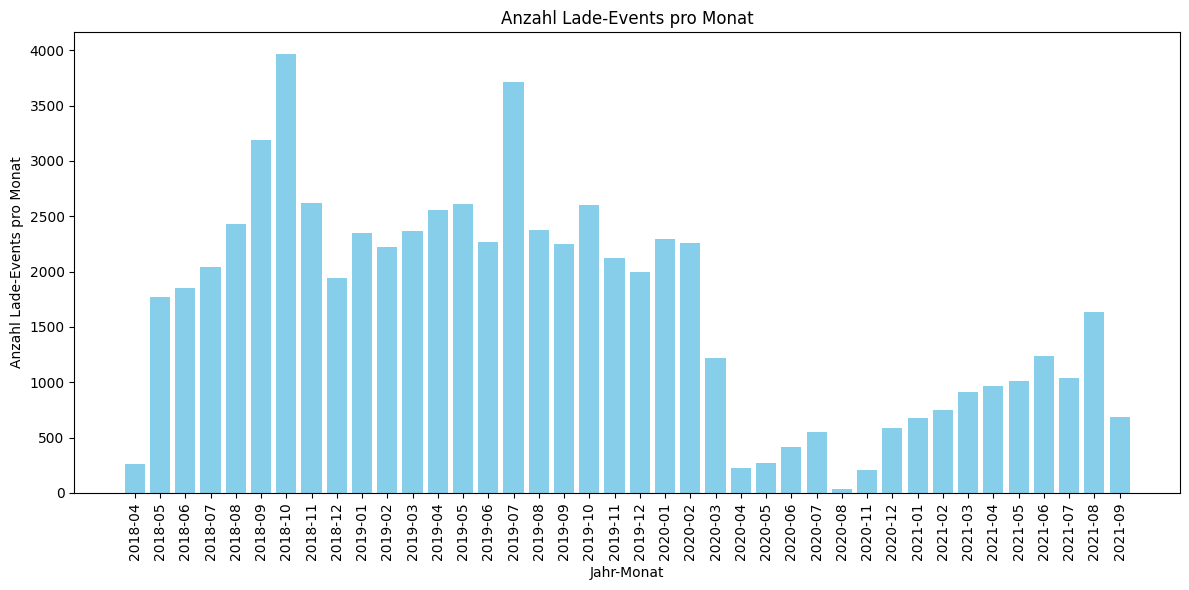

In [6]:
charging_set['connectionTime_date'] = pd.to_datetime(charging_set['connectionTime_date'])

# Jahr und Monat extrahieren
charging_set['year'] = charging_set['connectionTime_date'].dt.year
charging_set['month'] = charging_set['connectionTime_date'].dt.month

# Berechnung der durchschnittlichen Temperatur pro Jahr und Monat
avg_temperatures = charging_set.groupby(['year', 'month']).size().reset_index(name='count')

# Erstellen des Balkendiagramms
plt.figure(figsize=(12, 6))
# Kombiniere Jahr und Monat für die X-Achse, z.B. '2022-01' für Januar 2022
avg_temperatures['year_month'] = avg_temperatures['year'].astype(str) + '-' + avg_temperatures['month'].astype(str).str.zfill(2)

# Erstellen des Balkendiagramms
plt.bar(avg_temperatures['year_month'], avg_temperatures['count'], color='skyblue')

# Titel und Beschriftungen
plt.title('Anzahl Lade-Events pro Monat')
plt.xlabel('Jahr-Monat')
plt.ylabel('Anzahl Lade-Events pro Monat')

# Optional: X-Achse formatieren (dreh die Labels, damit sie lesbar sind)
plt.xticks(rotation=90)

# Layout optimieren
plt.tight_layout()

# Diagramm anzeigen
plt.show()